In [5]:
## https://planetarycomputer.microsoft.com/dataset/noaa-nclimgrid-monthly

import os, os.path
from pystac_client import Client
import planetary_computer as pc
import rioxarray
import rasterio as rio
import fiona
import pyproj
from shapely.geometry import shape, Point, Polygon, mapping
from functools import partial
from shapely.ops import transform
import urllib.request
import numpy as np
import geopandas as gpd
import pyproj
import rich
# Set the environment variable PC_SDK_SUBSCRIPTION_KEY, or set it here.
# The Hub sets PC_SDK_SUBSCRIPTION_KEY automatically.
pc.settings.set_subscription_key("st=2022-06-01T22%3A55%3A32Z&se=2022-06-02T23%3A40%3A32Z&sp=rl&sv=2020-06-12&sr=c&skoid=c85c15d6-d1ae-42d4-af60-e2ca0f81359b&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2022-06-02T20%3A23%3A33Z&ske=2022-06-09T20%3A23%3A33Z&sks=b&skv=2020-06-12&sig=U5e1SoZGZqIcunum5BKWcmsVi2bmS1tBsr94LPI%2BLoc%3D")

In [6]:
import pystac_client
import planetary_computer

catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

In [7]:
import fiona

shpfile = 'data/city_limit_4326.shp'

lyr = fiona.open(shpfile)
for feat in lyr:
    area_of_interest_city = feat['geometry']
    # print(area_of_interest)

left, bottom, right, top = lyr.bounds
area_of_interest = {
    "type": "Polygon",
    "coordinates": [
        [
            [left, bottom],
            [right, bottom],
            [right, top],
            [left, top],
            [left, bottom],
        ]
    ],
}

print(area_of_interest)

{'type': 'Polygon', 'coordinates': [[[-75.28030313034645, 39.867465570687145], [-74.9557457320632, 39.867465570687145], [-74.9557457320632, 40.137927528193686], [-75.28030313034645, 40.137927528193686], [-75.28030313034645, 39.867465570687145]]]}


In [10]:
## check on GEE, https://developers.google.com/earth-engine/datasets/catalog/USDA_NAIP_DOQQ
date_time = '2021-03-01'

search_particular = catalog.search(
    collections=["noaa-nclimgrid-monthly"], intersects=area_of_interest, datetime=date_time
)

items_tiles = search_particular.item_collection()

print(f"{len(items_tiles)} Items found in the 'particular' month")

1 Items found in the 'particular' month


In [11]:
outfolder = 'climate-monthly'
if not os.path.exists(outfolder): os.mkdir(outfolder)

## loop all the intersected tiles and download them all
for item in items_tiles:
    #href = pc.sign(item.assets["image"].href)
    href = item.assets["tavg"].href
    print(href)
    
    outfilename = os.path.join(outfolder, item.id + ".tif")
    urllib.request.urlretrieve(href, outfilename)

https://nclimgridwesteurope.blob.core.windows.net/nclimgrid-cogs/nclimgrid-monthly/nclimgrid-tavg-202103.tif?st=2024-03-13T03%3A38%3A44Z&se=2024-03-14T04%3A23%3A44Z&sp=rl&sv=2021-06-08&sr=c&skoid=c85c15d6-d1ae-42d4-af60-e2ca0f81359b&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2024-03-12T03%3A26%3A23Z&ske=2024-03-19T03%3A26%3A23Z&sks=b&skv=2021-06-08&sig=Ks%2BH4AQpDHlWsD4FcbJdt/zgoGMvToB8bqH01RoSAAE%3D


**Read and get the meta data of the raster**

In [13]:
nclim_file = 'climate-monthly/nclimgrid-202103.tif'
nclim_dataset = rio.open(nclim_file)
nclim_bounds = nclim_dataset.bounds
nclim_bounds


BoundingBox(left=-124.70833333, bottom=24.541665949999995, right=-66.99999538, top=49.37500127)

In [14]:
nclim_dataset.crs

CRS.from_epsg(4326)

In [15]:
nclim_dataset.meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': nan,
 'width': 1385,
 'height': 596,
 'count': 1,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(0.04166667, 0.0, -124.70833333,
        0.0, -0.04166667, 49.37500127)}

**Read the geotiff image for different bands**

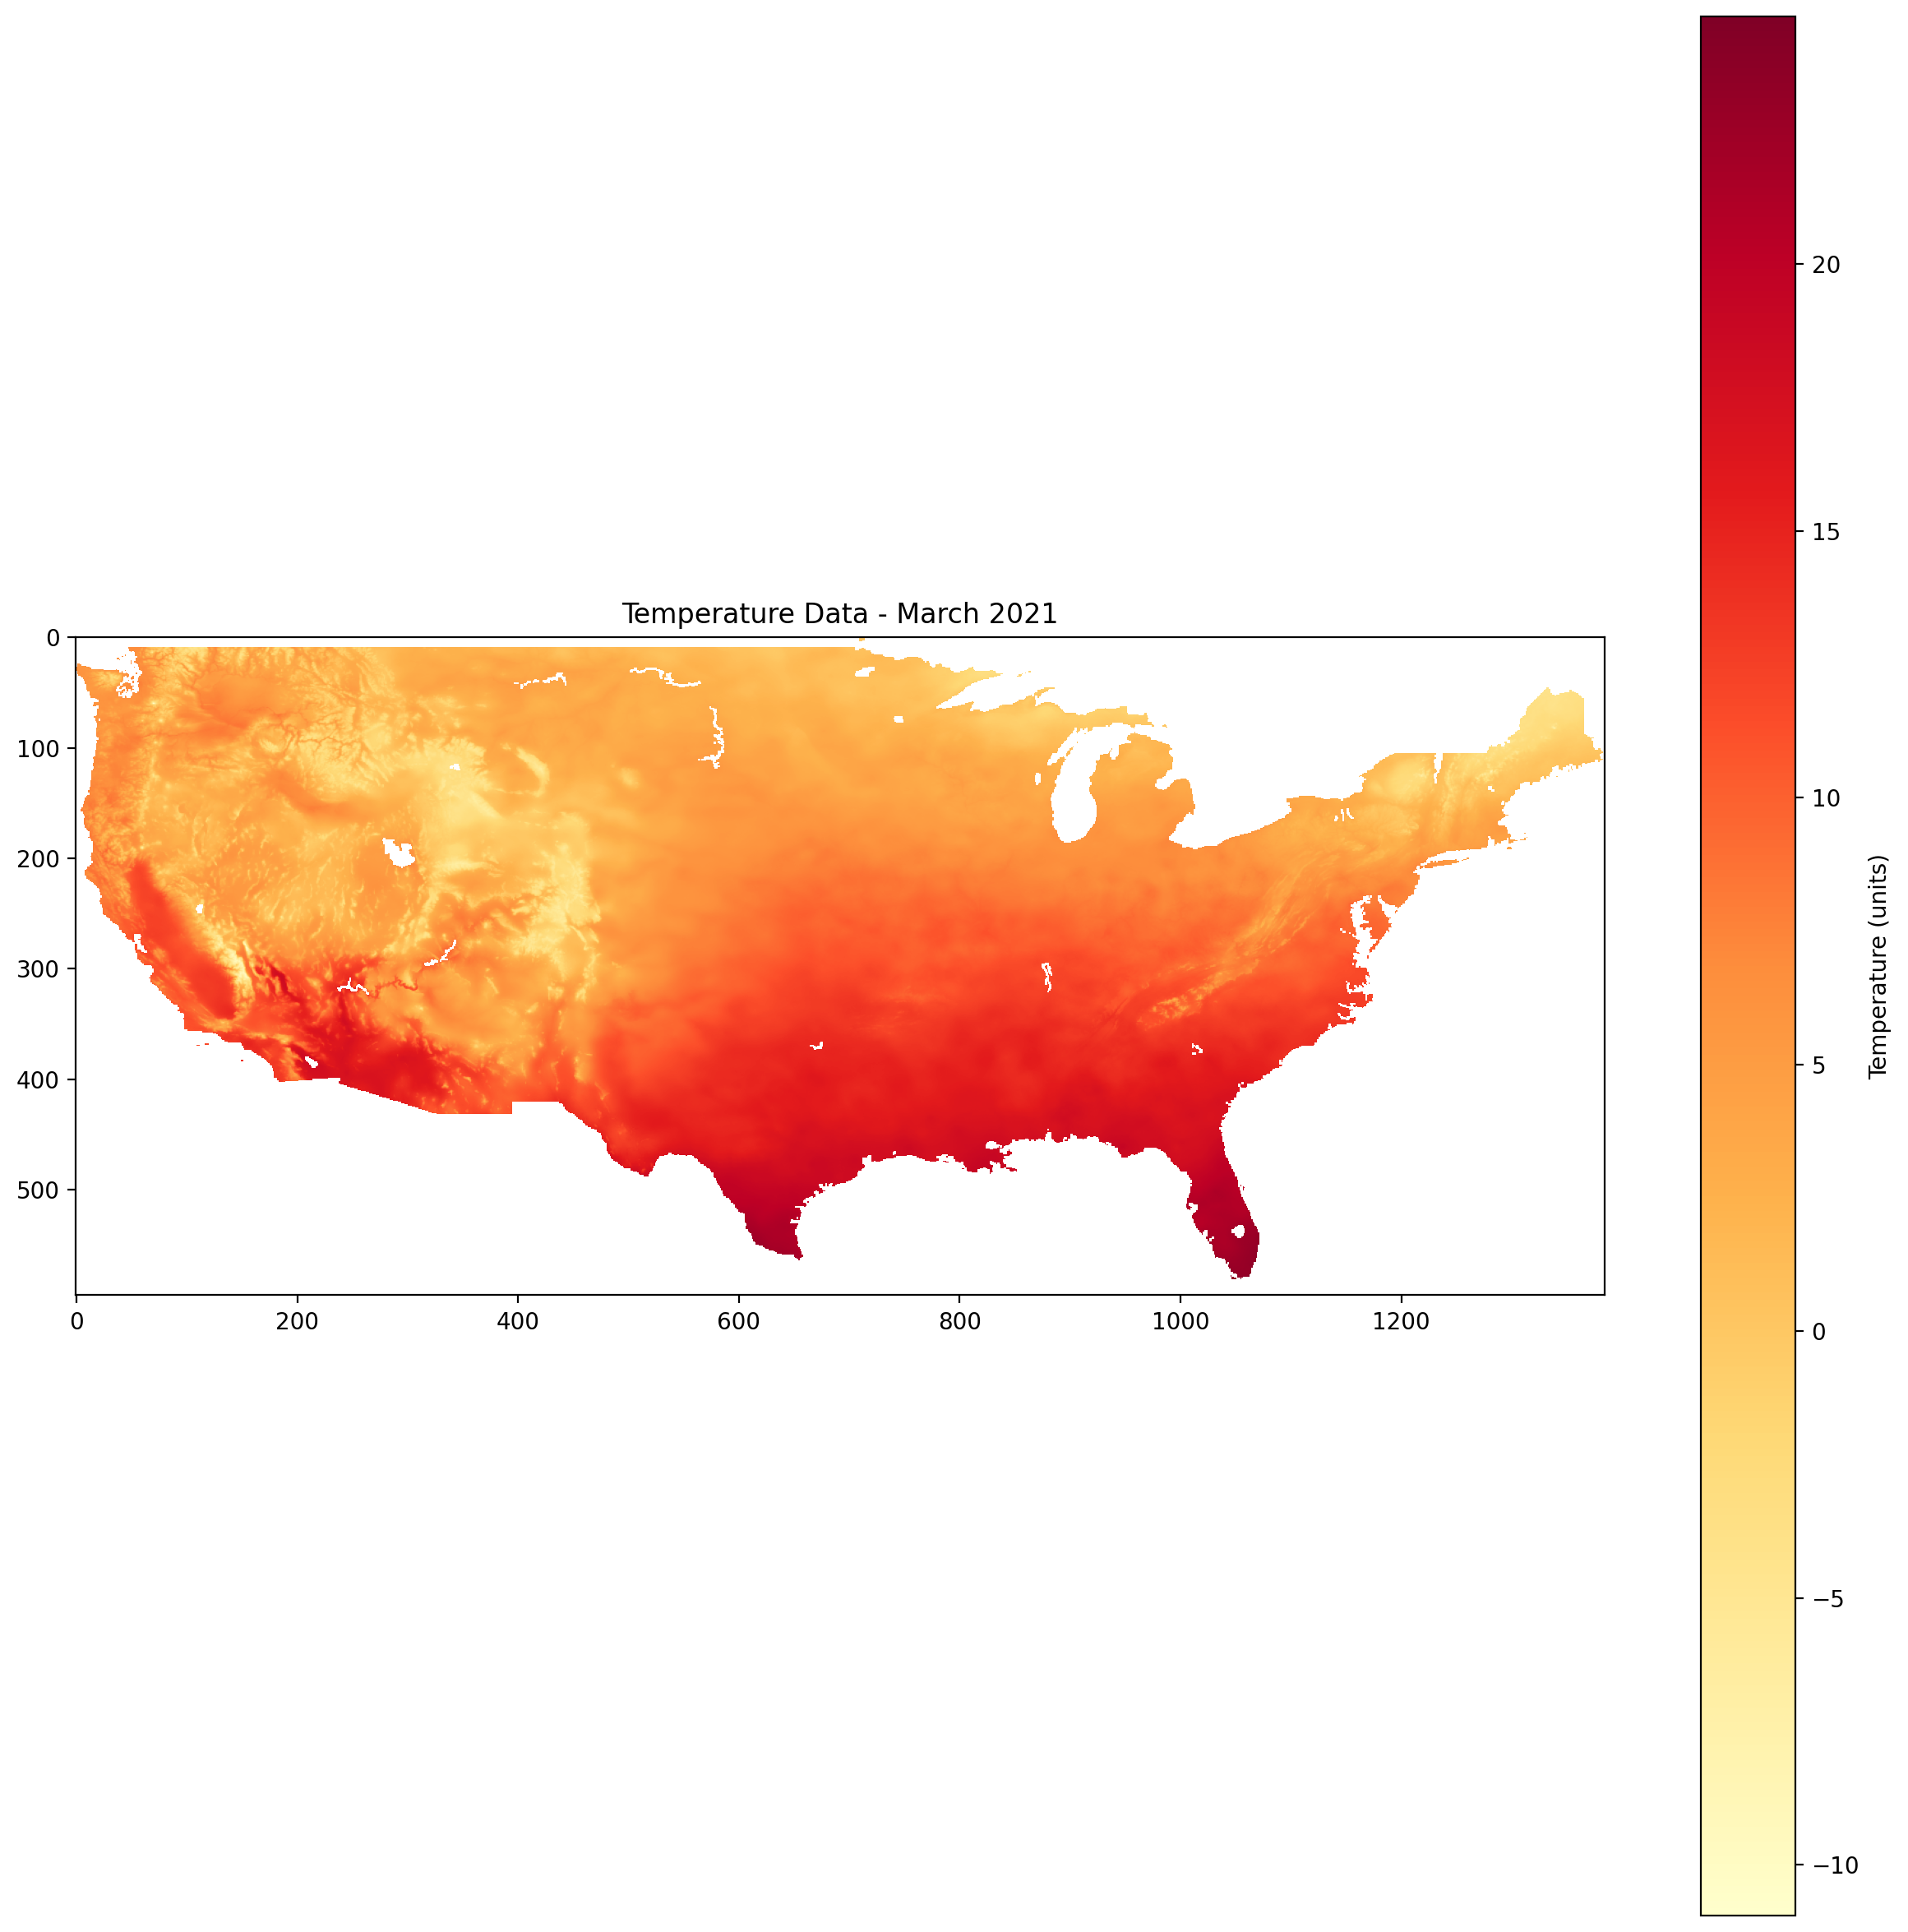

In [16]:
import numpy as np
from matplotlib import pyplot as plt

nclim_file = 'climate-monthly/nclimgrid-202103.tif'
nclim_dataset = rio.open(nclim_file)
# Read the temperature data (assuming it's a single-band raster)
temperature_data = nclim_dataset.read(1, masked=True)

# Plot the temperature data
plt.figure(figsize=(15, 15), dpi=200)
plt.imshow(temperature_data, cmap='YlOrRd')  # You can choose a different colormap if needed
plt.colorbar(label='Temperature (units)')  # Add a colorbar for reference
plt.title('Temperature Data - March 2021')  # Add a title if desired
plt.show()

**Overlay shapefile on raster data**

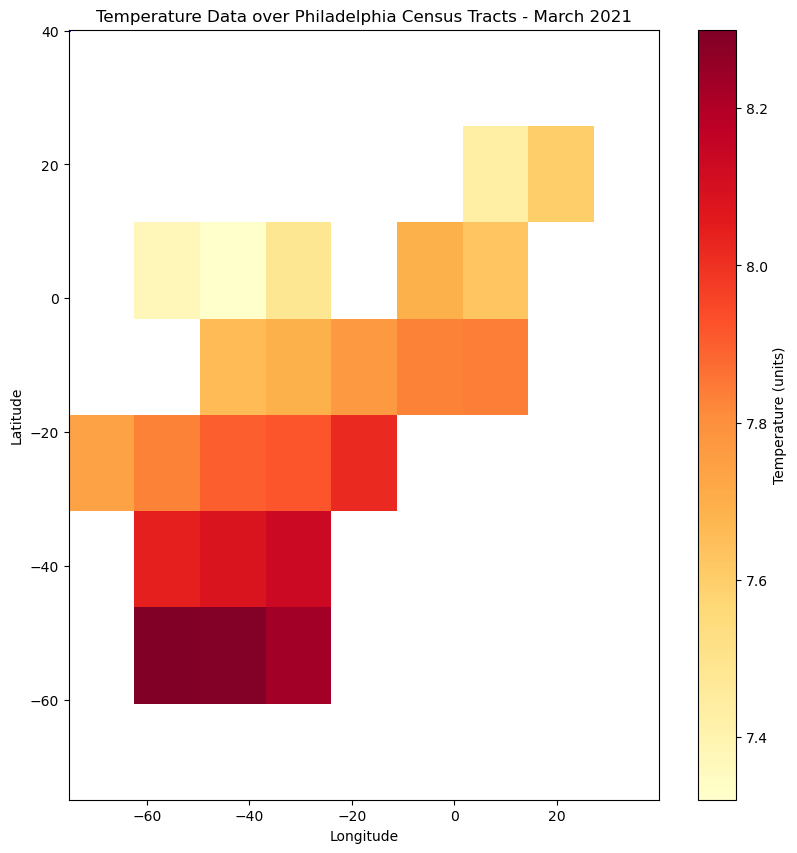

In [47]:
import geopandas as gpd
import rasterio as rio
from rasterio.plot import show


# Load the shapefile of census tracts for Philadelphia
shapefile_path = 'Census_Tracts/Census_Tracts_2010.shp'
census_tracts = gpd.read_file(shapefile_path)

# Define the extent of the raster to be the same as the census tracts shapefile
extent = census_tracts.total_bounds

# Load the temperature data raster
nclim_file = 'climate-monthly/nclimgrid-202103.tif'
with rio.open(nclim_file) as nclim_dataset:
    temperature_data, _ = rio.mask.mask(nclim_dataset, census_tracts.geometry, crop=True)
    temperature_data = temperature_data[0]

# Plot the temperature data over the census tracts
plt.figure(figsize=(10, 10))
plt.imshow(temperature_data, cmap='YlOrRd', extent=extent)  # Set extent to match shapefile
plt.colorbar(label='Temperature (units)')
census_tracts.plot(ax=plt.gca(), facecolor='none', edgecolor='blue')  # Plot the shapefile
plt.title('Temperature Data over Philadelphia Census Tracts - March 2021')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()
